In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
path = './data/ecommerce_customer_behavior.csv'

In [3]:
data = pd.read_csv(path)
data.columns = [x.lower().replace(' ', '_') for x in data.columns]
data = data.convert_dtypes()
data.drop(columns=['customer_id', 'city'], inplace=True)
data.head()

,gender,age,membership_type,total_spend,items_purchased,average_rating,discount_applied,days_since_last_purchase,satisfaction_level
0,Female,29,Gold,1120.2,14,4.6,True,25,Satisfied
1,Male,34,Silver,780.5,11,4.1,False,18,Neutral
2,Female,43,Bronze,510.75,9,3.4,True,42,Unsatisfied
3,Male,30,Gold,1480.3,19,4.7,False,12,Satisfied
4,Male,27,Silver,720.4,13,4.0,True,55,Unsatisfied


In [4]:
data.dtypes

gender                      string[python]
age                                  Int64
membership_type             string[python]
total_spend                        Float64
items_purchased                      Int64
average_rating                     Float64
discount_applied                   boolean
days_since_last_purchase             Int64
satisfaction_level          string[python]
dtype: object

In [6]:
print('Number of samples in the data:', data.shape[0])

Number of samples in the data: 350


## EDA

In [5]:
data.groupby('satisfaction_level')['gender'].value_counts()

satisfaction_level  gender
Neutral             Female    56
                    Male      51
Satisfied           Male      67
                    Female    58
Unsatisfied         Female    59
                    Male      57
Name: count, dtype: int64

In [6]:
data.groupby('satisfaction_level')['membership_type'].value_counts()

satisfaction_level  membership_type
Neutral             Bronze              56
                    Silver              51
Satisfied           Gold               117
                    Silver               8
Unsatisfied         Bronze              58
                    Silver              58
Name: count, dtype: int64

In [7]:
data.groupby('satisfaction_level')['discount_applied'].value_counts()

satisfaction_level  discount_applied
Neutral             False               107
Satisfied           False                66
                    True                 59
Unsatisfied         True                116
Name: count, dtype: Int64

In [8]:
data.select_dtypes(exclude=['string', 'boolean']).columns

Index(['age', 'total_spend', 'items_purchased', 'average_rating',
       'days_since_last_purchase'],
      dtype='object')

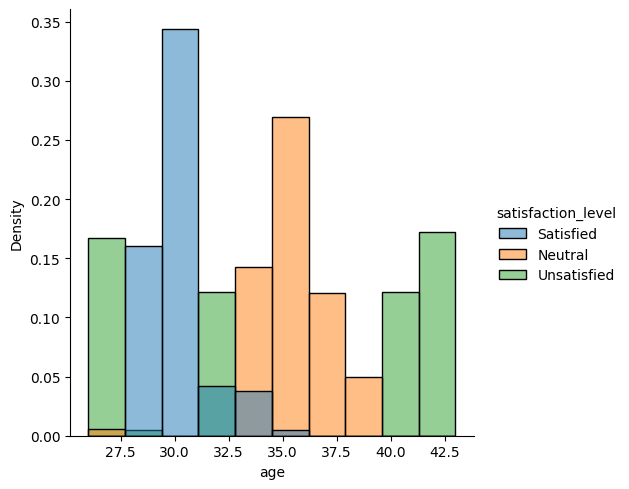

In [9]:
sns.displot(data, x="age", hue="satisfaction_level", stat="density", common_norm=False)

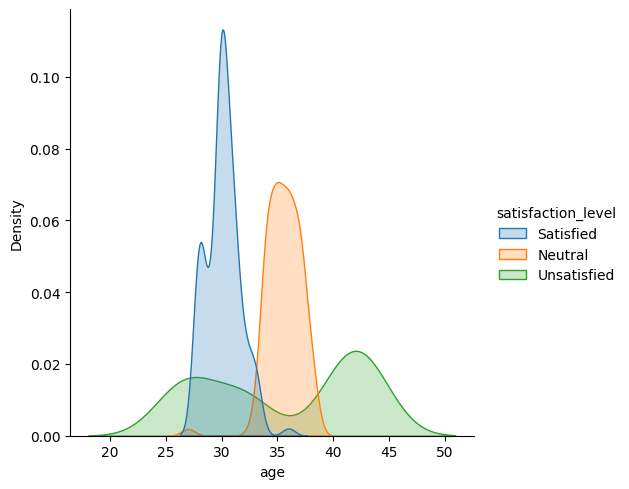

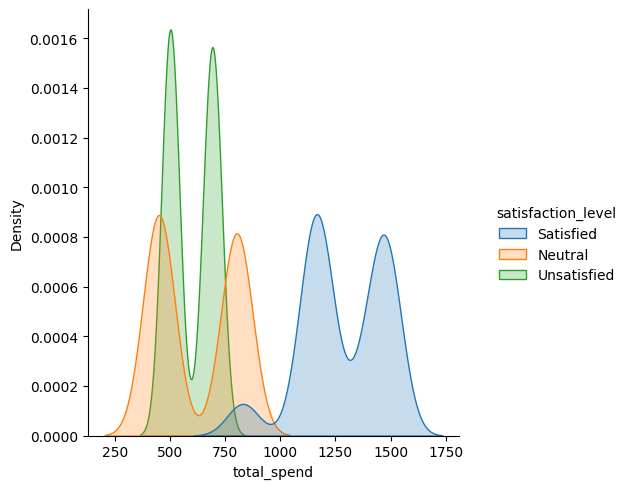

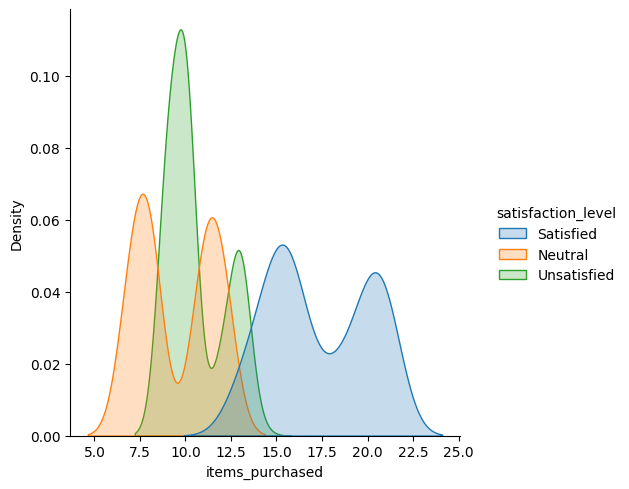

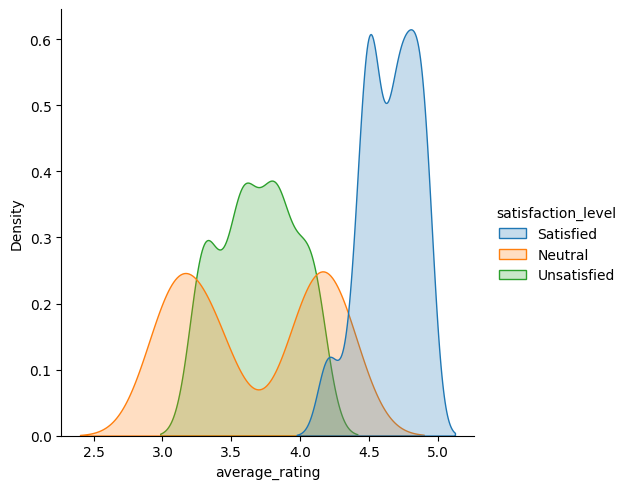

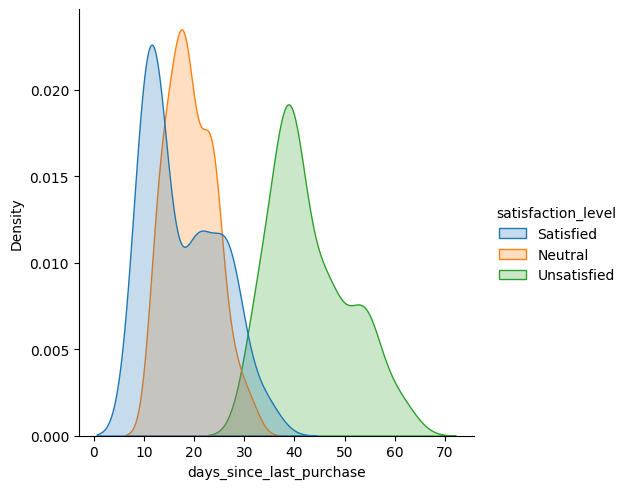

In [10]:
for column in data.select_dtypes(exclude=['string', 'boolean']).columns:
    sns.displot(data, x=column, hue="satisfaction_level", kind="kde", fill=True).set_titles(column)

## Preparing data

In [11]:
data['satisfaction_level_encoded'] = pd.Categorical(data['satisfaction_level']).codes

In [12]:
data.head()

,gender,age,membership_type,total_spend,items_purchased,average_rating,discount_applied,days_since_last_purchase,satisfaction_level,satisfaction_level_encoded
0,Female,29,Gold,1120.2,14,4.6,True,25,Satisfied,1
1,Male,34,Silver,780.5,11,4.1,False,18,Neutral,0
2,Female,43,Bronze,510.75,9,3.4,True,42,Unsatisfied,2
3,Male,30,Gold,1480.3,19,4.7,False,12,Satisfied,1
4,Male,27,Silver,720.4,13,4.0,True,55,Unsatisfied,2


In [13]:
X_org = data.drop(columns=['satisfaction_level', 'satisfaction_level_encoded']).copy()
y = data['satisfaction_level_encoded'].copy()

In [14]:
X_org.head()

,gender,age,membership_type,total_spend,items_purchased,average_rating,discount_applied,days_since_last_purchase
0,Female,29,Gold,1120.2,14,4.6,True,25
1,Male,34,Silver,780.5,11,4.1,False,18
2,Female,43,Bronze,510.75,9,3.4,True,42
3,Male,30,Gold,1480.3,19,4.7,False,12
4,Male,27,Silver,720.4,13,4.0,True,55


In [15]:
X_org['discount_applied'] = X_org['discount_applied'] * 1
X_org['binary_gender'] = np.where(X_org['gender'] == 'Female', 1, 0)

In [16]:
# Prepare membership_type as dummy variables
X_org_mtb = pd.get_dummies(X_org['membership_type'], drop_first=True, prefix='membership_type') * 1
X_org_mtb.head()

,membership_type_Gold,membership_type_Silver
0,1,0
1,0,1
2,0,0
3,1,0
4,0,1


In [17]:
X_final = pd.concat([X_org[['age', 'total_spend', 'items_purchased', 'average_rating', 'discount_applied']], X_org_mtb], axis=1)
X_final.head()

,age,total_spend,items_purchased,average_rating,discount_applied,membership_type_Gold,membership_type_Silver
0,29,1120.2,14,4.6,1,1,0
1,34,780.5,11,4.1,0,0,1
2,43,510.75,9,3.4,1,0,0
3,30,1480.3,19,4.7,0,1,0
4,27,720.4,13,4.0,1,0,1


## Active learning

In [18]:
# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

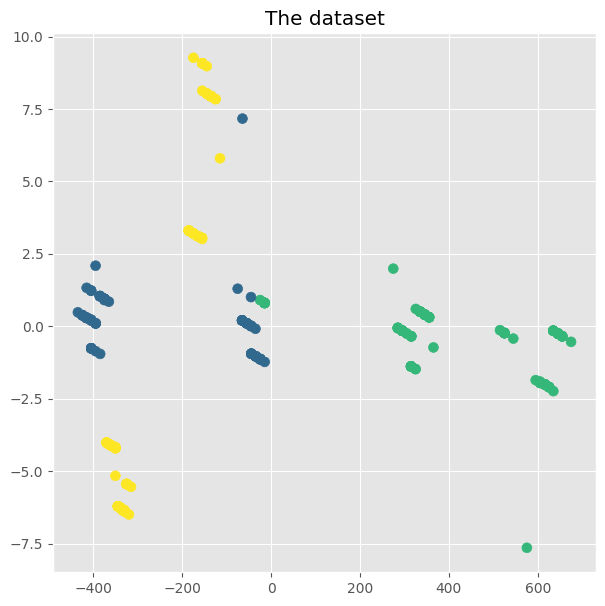

In [20]:
# visualizing the classes
with plt.style.context('ggplot'):
    plt.figure(figsize=(7, 7))
    pca = PCA(n_components=2).fit_transform(X_final)
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=y, cmap='viridis', s=50)
    plt.title('The dataset')
    plt.show()

## Initializing the committee

In [21]:
# from copy import deepcopy

In [22]:
X_final.values

array([[29, 1120.2, 14, ..., 1, 1, 0],
       [34, 780.5, 11, ..., 0, 0, 1],
       [43, 510.75, 9, ..., 1, 0, 0],
       ...,
       [30, 1190.8, 16, ..., 1, 1, 0],
       [34, 780.2, 11, ..., 0, 0, 1],
       [43, 515.75, 10, ..., 1, 0, 0]], dtype=object)

In [23]:
# generate the pool
X_pool = X_final.values.copy()
y_pool = y.values.copy()

In [28]:
X_pool.shape

(350, 7)

In [29]:
y_pool

array([ 1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  1,  2,  1,  2,
        0,  1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  1,  2,  1,
        2,  0,  1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  0,  2,
        1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  1,  2,  1,  2,  0,  1,  0,
        2,  1,  2, -1,  1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,
        0,  2,  1,  2,  0,  1,  1,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,
        1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,
        0,  1,  1,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  0,  2,  1,
        2,  0,  1,  0,  2,  1,  2, -1,  1,  0,  2,  1,  2,  0,  1,  0,  2,
        1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  1,  2,  1,  2,  0,  1,  0,
        2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,
        0,  2,  1,  2,  0,  1,  1,  2,  1,  2,  0,  1,  0,  1,  2,  0,  1,
        0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,  1,  0,  2,  1,  2,  0,
        1,  0,  2,  1,  2

In [25]:
# pip install git+https://github.com/modAL-python/modAL.git

from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling

In [26]:
# initializing Committee members
n_members = 2
learner_list = list()

In [30]:
for member_idx in range(n_members):
    # initial training data
    n_initial = 2
    train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
    X_train = X_pool[train_idx]
    y_train = y_pool[train_idx]

    # creating a reduced copy of the data with the known instances removed
    X_pool = np.delete(X_pool, train_idx, axis=0)
    y_pool = np.delete(y_pool, train_idx)

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

    print('committee member %d trained' % (member_idx + 1))
    print('committee size: %d' % len(learner_list))
    print(X_pool.shape)

committee member 1 trained
committee size: 1
(348, 7)
committee member 2 trained
committee size: 2
(346, 7)


In [31]:
# assembling the committee
committee = Committee(learner_list=learner_list)

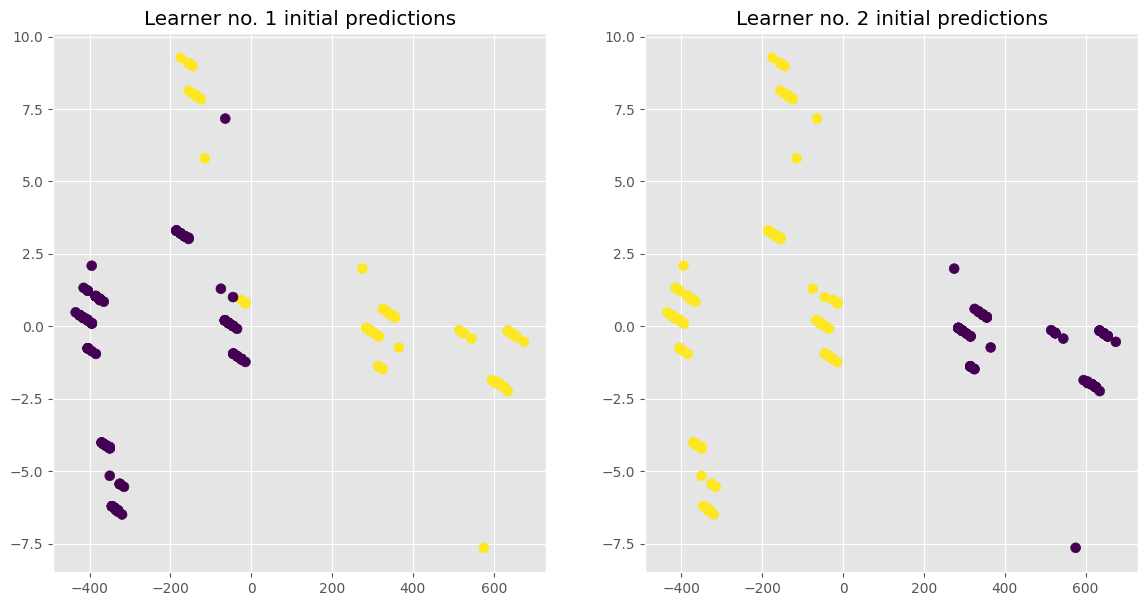

In [32]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(X_final.values), cmap='viridis', s=50)
        plt.title('Learner no. %d initial predictions' % (learner_idx + 1))
    plt.show()

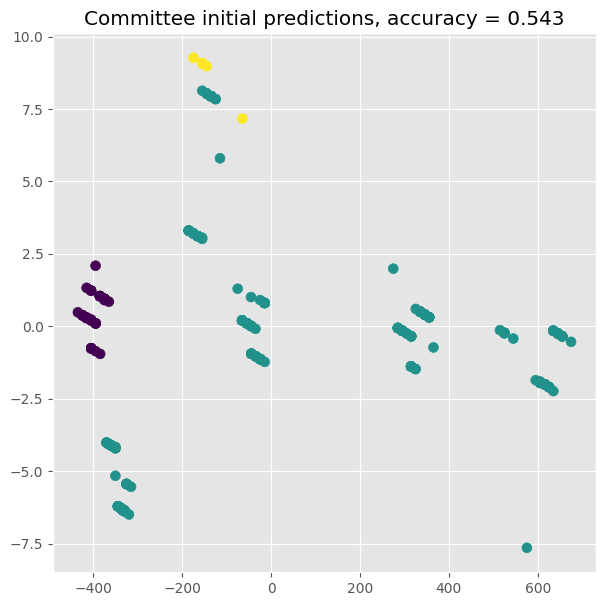

In [33]:
unqueried_score = committee.score(X_final.values, y)

with plt.style.context('ggplot'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(X_final.values)
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee initial predictions, accuracy = %1.3f' % unqueried_score)
    plt.show()

## Active learning

In [34]:
performance_history = [unqueried_score]

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(X_final.values, y))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

    print('query: ', idx + 1)
    print('committee size: %d' % len(committee))
    print('queried instance: ', query_idx)
    print('performance after query: ', committee.score(X_final.values, y))
    print(X_pool.shape)
    print('---------------\n')

query:  1
committee size: 2
queried instance:  [1]
performance after query:  0.64
(345, 7)
---------------

query:  2
committee size: 2
queried instance:  [1]
performance after query:  0.9714285714285714
(344, 7)
---------------

query:  3
committee size: 2
queried instance:  [0]
performance after query:  0.9314285714285714
(343, 7)
---------------

query:  4
committee size: 2
queried instance:  [1]
performance after query:  0.9714285714285714
(342, 7)
---------------

query:  5
committee size: 2
queried instance:  [1]
performance after query:  0.9714285714285714
(341, 7)
---------------

query:  6
committee size: 2
queried instance:  [0]
performance after query:  0.9714285714285714
(340, 7)
---------------

query:  7
committee size: 2
queried instance:  [0]
performance after query:  0.9714285714285714
(339, 7)
---------------

query:  8
committee size: 2
queried instance:  [0]
performance after query:  0.9714285714285714
(338, 7)
---------------

query:  9
committee size: 2
queried in

### Reaching consensus

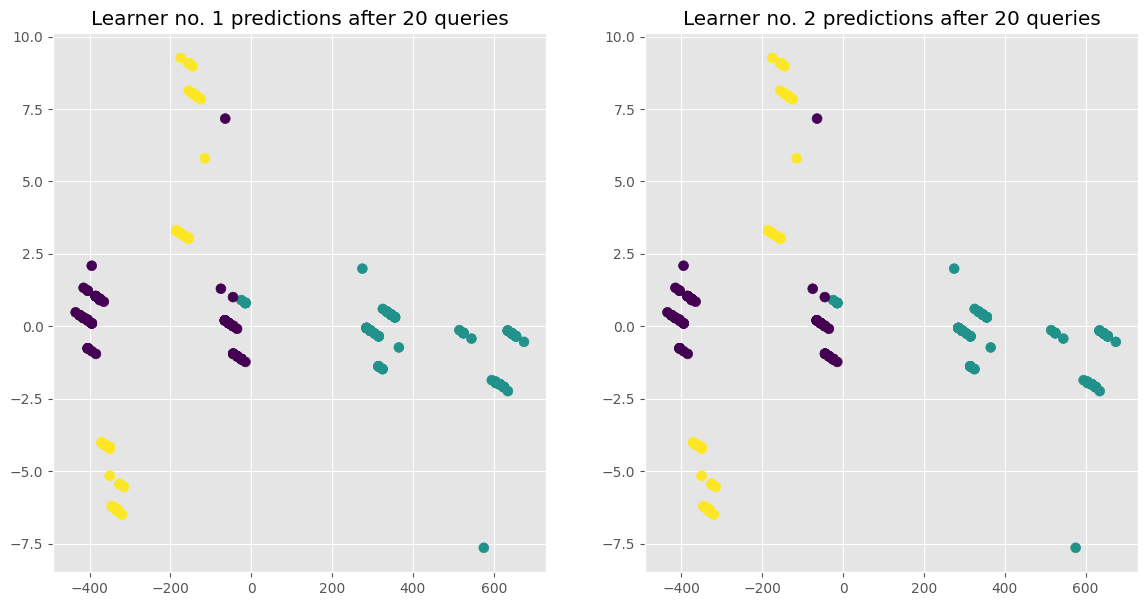

In [35]:
# visualizing the final predictions per learner
with plt.style.context('ggplot'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(X_final.values), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries))
    plt.show()

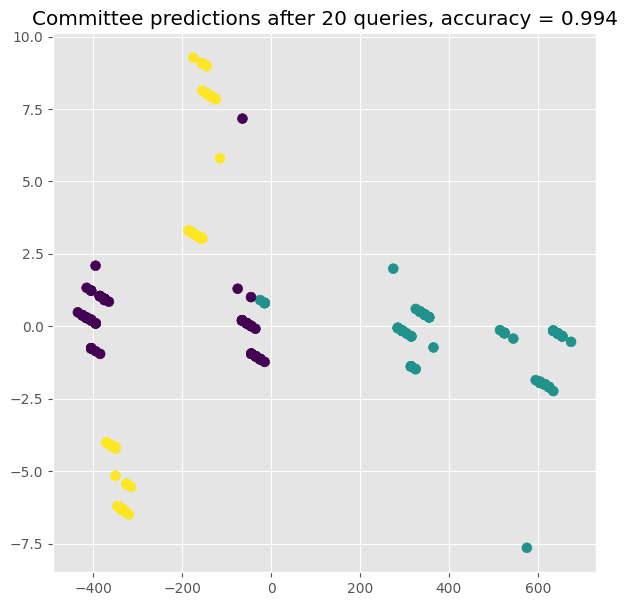

In [36]:
# visualizing the Committee's predictions
with plt.style.context('ggplot'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(X_final.values)
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries, committee.score(X_final.values, y)))
    plt.show()

In [37]:
uncertainty_sampling(committee, X_final.values)
#uncertainty(X_final.values)
#.predict(X_final.values)

(array([204], dtype=int64), array([0.405]))

In [39]:
probabilities = committee.predict_proba(X_final.values)
probabilities

array([[0.   , 0.975, 0.025],
       [0.82 , 0.095, 0.085],
       [0.075, 0.   , 0.925],
       ...,
       [0.   , 0.985, 0.015],
       [0.835, 0.14 , 0.025],
       [0.125, 0.   , 0.875]])

In [40]:
probabilities[204, :]

array([0.595, 0.225, 0.18 ])

In [41]:
probabilities.max(axis=0)

array([0.985, 1.   , 0.98 ])

In [45]:
# https://modal-python.readthedocs.io/en/latest/content/query_strategies/uncertainty_sampling.html
uncertain_probabilities = 1 - probabilities.max(axis=1)
uncertain_probabilities

array([0.025, 0.18 , 0.075, 0.   , 0.17 , 0.015, 0.015, 0.065, 0.05 ,
       0.015, 0.04 , 0.025, 0.05 , 0.14 , 0.065, 0.   , 0.02 , 0.015,
       0.025, 0.25 , 0.125, 0.   , 0.25 , 0.09 , 0.015, 0.205, 0.08 ,
       0.015, 0.035, 0.015, 0.015, 0.235, 0.065, 0.   , 0.035, 0.015,
       0.04 , 0.18 , 0.125, 0.   , 0.17 , 0.015, 0.015, 0.37 , 0.16 ,
       0.015, 0.035, 0.025, 0.015, 0.25 , 0.125, 0.   , 0.25 , 0.09 ,
       0.015, 0.205, 0.08 , 0.015, 0.035, 0.015, 0.015, 0.235, 0.065,
       0.   , 0.035, 0.015, 0.04 , 0.18 , 0.125, 0.   , 0.17 , 0.015,
       0.015, 0.37 , 0.16 , 0.015, 0.035, 0.025, 0.015, 0.25 , 0.125,
       0.   , 0.25 , 0.09 , 0.015, 0.205, 0.08 , 0.015, 0.035, 0.015,
       0.015, 0.235, 0.065, 0.   , 0.035, 0.015, 0.04 , 0.18 , 0.125,
       0.   , 0.17 , 0.015, 0.015, 0.37 , 0.16 , 0.015, 0.035, 0.025,
       0.015, 0.25 , 0.125, 0.   , 0.25 , 0.09 , 0.015, 0.205, 0.08 ,
       0.015, 0.035, 0.015, 0.015, 0.235, 0.065, 0.   , 0.035, 0.015,
       0.04 , 0.18 ,

In [46]:
sorted_array = np.sort(uncertain_probabilities)[::-1]  # Sort the array in descending order
indexes = np.argsort(uncertain_probabilities)[::-1]  # Get the corresponding indexes

print("Sorted array:", sorted_array)
print("Indexes:", indexes)

Sorted array: [0.405 0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.37
 0.37  0.37  0.37  0.34  0.275 0.265 0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.235 0.235 0.235 0.235
 0.235 0.235 0.235 0.205 0.205 0.205 0.205 0.205 0.205 0.185 0.18  0.18
 0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.17  0.17
 0.17  0.17  0.17  0.17  0.17  0.165 0.165 0.165 0.165 0.165 0.165 0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.14  0.14  0.14  0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.1   0.1   0.1   0.1   0.09
 0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09
 0.09  0.09  0.09  0.09  0.09  0.08  0.08  0.08  0.08  0.08  0.08  0.08
 0.08  0.075 0.065 0.065 0.065 0.065 0.065 0.065 0.065 0.065 0.065 0.065
 0.065 0.065 0.065 0.06  0.06  0.05  0.05  0.0

In [48]:
df_uncertainties = pd.DataFrame({'idx': indexes, 'uncertainty': sorted_array})
df_uncertainties

,idx,uncertainty
0,204,0.405
1,228,0.370
2,175,0.370
3,103,0.370
4,145,0.370
...,...,...
345,51,0.000
346,278,0.000
347,290,0.000
348,39,0.000


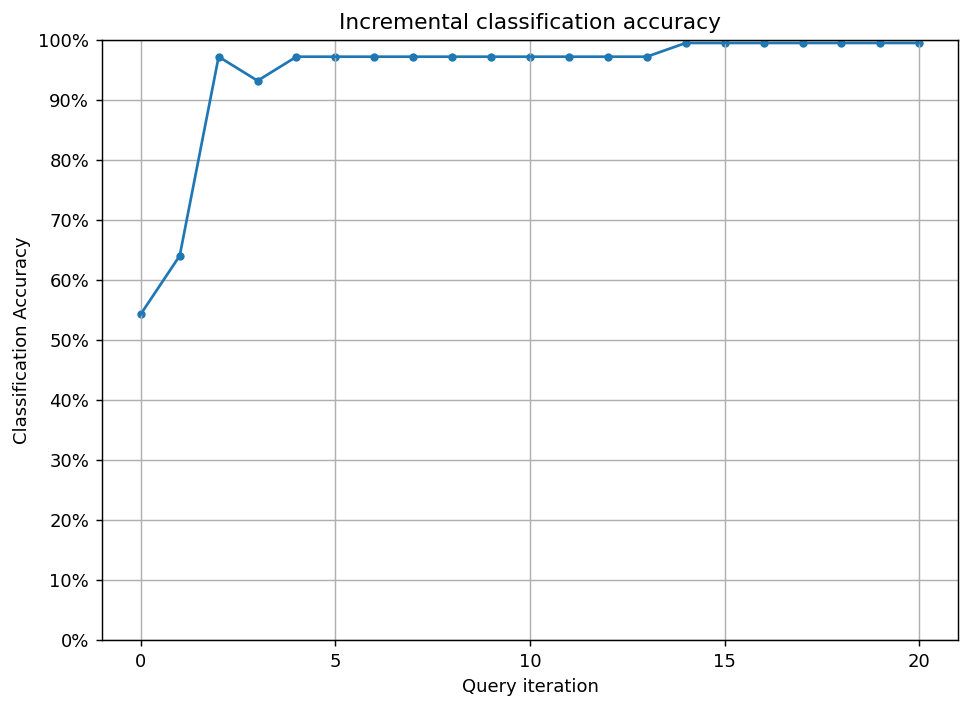

In [44]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

## Predictions

In [59]:
committee.predict(X_final.values)

array([1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1,
       2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0,
       2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0,
       1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0,
       2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0,
       1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1,
       2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0,
       2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0,
       1, 0, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2,
       0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2,
       1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1,
       0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2,
       0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0,

In [60]:
committee.predict(X_final.values[2].reshape(1, -1))

array([2], dtype=int8)

In [61]:
committee.predict_proba(X_final.values[2].reshape(1, -1))

array([[0.075, 0.   , 0.925]])